In [1]:
# notebooks/create_scenarios.ipynb

import sys
sys.path.append("..")   
from scripts.create_data import create_data_scenario
from scripts.logger import log_scenario_folder, mark_log_as_finished, create_new_id
import random
from datetime import datetime
import os

logs_id = create_new_id("scenario")

amount_aircraft = 6
training_or_testing = 'TEMP'
template_folder = "../data/Template"
# name = "superdiverse"
name = "one-of-all"

airports = [
    'AMS', 'CDG', 'FRA', 'LHR', 'MAD', 'MUC', 'ORY', 'TXL', 'VIE', 'ZRH', 
    'BCN', 'BRU', 'CPH', 'DUB', 'IST'
]
aircraft_types = [
    {
        'Model': 'B737', 'Family': 'Boeing', 'Config': '0/0/123', 'Dist': 5000, 
        'Cost/h': 1800.0, 'TurnRound': 30, 'Transit': 30, 'Orig': ['CFE'], 'Maint': ['NULL']
    },
]
config_dict = {
    'DelayCosts': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 100.0}],
    'CancellationCostsOutbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 500.0}],
    'CancellationCostsInbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 600.0}],
    'DowngradingCosts': [{'FromCabin': 'Business', 'ToCabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 200.0}],
    'PenaltyCosts': [200, 300, 400],
    'Weights': [1.0, 0.5, 0.2],
}

combinations = [
    ("deterministic", 1, "certain"),
    ("deterministic", 2, "certain"),
    ("stochastic", 1, "low"),
    ("stochastic", 1, "medium"), 
    ("stochastic", 1, "high"),
    ("stochastic", 2, "low"),
    ("stochastic", 2, "medium"),
    ("stochastic", 2, "high"),
    ("mixed", 2, "low"),
    ("mixed", 2, "medium"),
    ("mixed", 2, "high"),
]

num_scenarios_per_combination = 1

total_amount_scenarios = len(combinations) * num_scenarios_per_combination
# We will store all scenarios in this single folder
data_root_folder = f"../data/{training_or_testing}/{amount_aircraft}ac-{total_amount_scenarios}-{name}/"
os.makedirs(data_root_folder, exist_ok=True)

# Collect all outputs for logging at the end
logging_outputs = {}
count = 0
for probabilistic_type, num_disruptions, probabilities_values_type in combinations:
    # Validate mixed type has even number of disruptions
    if probabilistic_type == 'mixed' and num_disruptions % 2 != 0:
        raise ValueError(f"Mixed type must have even number of disruptions, got {num_disruptions}")

    # Determine disrupted/uncertain counts
    if probabilistic_type == 'stochastic':
        amount_aircraft_disrupted = 0
        amount_aircraft_uncertain = num_disruptions
    elif probabilistic_type == 'deterministic':
        amount_aircraft_disrupted = num_disruptions
        amount_aircraft_uncertain = 0
    elif probabilistic_type == 'mixed':
        amount_aircraft_disrupted = num_disruptions // 2
        amount_aircraft_uncertain = num_disruptions // 2
    else:
        raise ValueError(f"Invalid probabilistic_type: {probabilistic_type}")

    # Determine probability bounds
    if probabilistic_type != 'deterministic':
        if probabilities_values_type == 'high':
            prob_lower_bound = 0.5
            prob_upper_bound = 1.0
        elif probabilities_values_type == 'low':
            prob_lower_bound = 0.0
            prob_upper_bound = 0.5
        elif probabilities_values_type == 'medium':
            prob_lower_bound = 0.25
            prob_upper_bound = 0.75
        else:
            raise ValueError(f"Invalid probabilities_values_type: {probabilities_values_type}")
    else:
        prob_lower_bound = 0.0
        prob_upper_bound = 0.0
        probabilities_values_type = 'na'

    logging_inputs = {
        "num_scenarios": num_scenarios_per_combination,
        "aircraft_range": (amount_aircraft, amount_aircraft),
        "amount_aircraft_disrupted": amount_aircraft_disrupted,
        "amount_aircraft_uncertain": amount_aircraft_uncertain,
        "average_flights_per_aircraft": 12,
        "std_dev_flights_per_aircraft": 1,
        "min_delta_start_unavailability": 120,
        "max_delta_start_unavailability": 480,
        "min_period_unavailability": 120,
        "max_period_unavailability": 480,
        "probability_range": (prob_lower_bound, prob_upper_bound),
        "probability_distribution": 'uniform',
        "clear_one_random_aircraft": True,
        "clear_random_flights": True,
        "switch_one_random_flight_to_the_cleared_aircraft": True,
        "first_flight_dep_time_range": (6, 8),
        "flight_length_range": (2, 5),
        "time_between_flights_range": (0, 2),
        "percentage_no_turn_time": 0.8,
    }

    for i in range(1, logging_inputs["num_scenarios"] + 1):
        count += 1
        # Scenario naming format: 
        # {probabilistic_type}_{probabilities_values_type}_Scenario_{i:03d}
        # scenario_name = f"{probabilistic_type}_{probabilities_values_type}_Scenario_{i:03d}"
        scenario_name = f"Scenario_{count:05d}"

        recovery_start_date = datetime(2024, 9, random.randint(1, 30)).strftime('%d/%m/%y')
        recovery_start_time = f'{random.randint(5, 7)}:00'
        recovery_end_date = recovery_start_date
        recovery_end_time = f'{random.randint(20, 23)}:{random.choice(["00", "30"])}'

        data_folder, inputs, outputs = create_data_scenario(
            scenario_name=scenario_name,
            template_folder=template_folder,
            data_root_folder=data_root_folder,
            aircraft_types=aircraft_types,
            total_aircraft_range=logging_inputs["aircraft_range"],
            amount_aircraft_disrupted=logging_inputs["amount_aircraft_disrupted"],
            amount_aircraft_uncertain=logging_inputs["amount_aircraft_uncertain"],
            min_delta_start_unavailability=logging_inputs["min_delta_start_unavailability"],
            max_delta_start_unavailability=logging_inputs["max_delta_start_unavailability"],
            min_period_unavailability=logging_inputs["min_period_unavailability"],
            max_period_unavailability=logging_inputs["max_period_unavailability"],
            average_flights_per_aircraft=logging_inputs["average_flights_per_aircraft"],
            std_dev_flights_per_aircraft=logging_inputs["std_dev_flights_per_aircraft"],
            airports=airports,
            config_dict=config_dict,
            recovery_start_date=recovery_start_date,
            recovery_start_time=recovery_start_time,
            recovery_end_date=recovery_end_date,
            recovery_end_time=recovery_end_time,
            clear_one_random_aircraft=logging_inputs["clear_one_random_aircraft"],
            clear_random_flights=logging_inputs["clear_random_flights"],
            switch_one_random_flight_to_the_cleared_aircraft=logging_inputs["switch_one_random_flight_to_the_cleared_aircraft"],
            probability_range=logging_inputs["probability_range"],
            probability_distribution=logging_inputs["probability_distribution"],
            first_flight_dep_time_range=logging_inputs["first_flight_dep_time_range"],
            flight_length_range=logging_inputs["flight_length_range"],
            time_between_flights_range=logging_inputs["time_between_flights_range"],
            percentage_no_turn_time=logging_inputs["percentage_no_turn_time"],
        )

        logging_outputs[scenario_name] = outputs

# Log all scenarios together
log_scenario_folder(
    logs_id=logs_id,
    scenario_folder_path=data_root_folder,
    inputs={"combinations": combinations, "per_combination_scenarios": num_scenarios_per_combination, "aircraft": amount_aircraft},
    outputs=logging_outputs
)

# Mark the log as finished
mark_log_as_finished(logs_id, additional_info=data_root_folder)
# Print the path where scenarios were saved
print(f"\nScenarios saved to: {data_root_folder}")


New ID created: scenario_71
Data creation for scenario Scenario_00001 completed with 6 aircraft and 28 flights.
Data creation for scenario Scenario_00002 completed with 6 aircraft and 23 flights.
Data creation for scenario Scenario_00003 completed with 6 aircraft and 22 flights.
Data creation for scenario Scenario_00004 completed with 6 aircraft and 29 flights.
Data creation for scenario Scenario_00005 completed with 6 aircraft and 24 flights.
Data creation for scenario Scenario_00006 completed with 6 aircraft and 27 flights.
Data creation for scenario Scenario_00007 completed with 6 aircraft and 23 flights.
Data creation for scenario Scenario_00008 completed with 6 aircraft and 22 flights.
Data creation for scenario Scenario_00009 completed with 6 aircraft and 26 flights.
Data creation for scenario Scenario_00010 completed with 6 aircraft and 25 flights.
Data creation for scenario Scenario_00011 completed with 6 aircraft and 23 flights.
Scenario logged to ../logs/scenarios/scenario_fo

### Visualize them

Processing scenario: Scenario_00014
{'B737#1': {'StartDate': '05/09/24', 'StartTime': '11:11', 'EndDate': '05/09/24', 'EndTime': '18:41', 'Probability': 1.0}}

Current State:
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12 |   F13 Dep13 Arr13 |   F14 Dep14 Arr14 |   F15 Dep15 Arr15 |   F16 Dep16 Arr16 |   F17 Dep17 Arr17
   1   1.00    311   761 |    24   165   361 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   

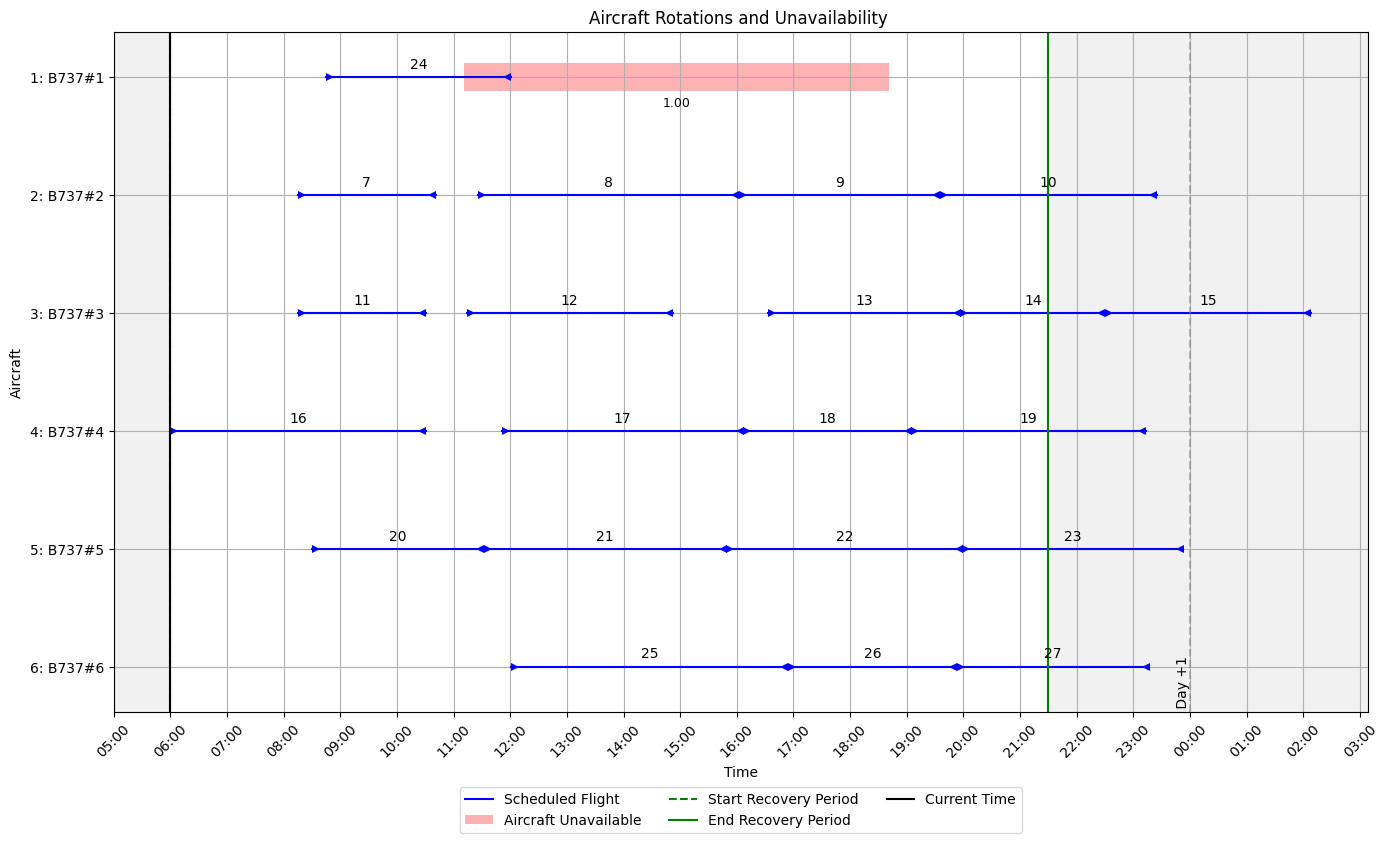

FLIGHTS DICT: {7: {'Orig': 'BRU', 'Dest': 'TXL', 'DepTime': '08:15', 'ArrTime': '10:41', 'PrevFlight': 0}, 8: {'Orig': 'CPH', 'Dest': 'VIE', 'DepTime': '11:26', 'ArrTime': '16:02', 'PrevFlight': 0}, 9: {'Orig': 'BRU', 'Dest': 'ZRH', 'DepTime': '16:02', 'ArrTime': '19:35', 'PrevFlight': 0}, 10: {'Orig': 'DUB', 'Dest': 'FRA', 'DepTime': '19:35', 'ArrTime': '23:25', 'PrevFlight': 0}, 11: {'Orig': 'LHR', 'Dest': 'CDG', 'DepTime': '08:15', 'ArrTime': '10:31', 'PrevFlight': 0}, 12: {'Orig': 'MUC', 'Dest': 'TXL', 'DepTime': '11:14', 'ArrTime': '14:52', 'PrevFlight': 0}, 13: {'Orig': 'CPH', 'Dest': 'MAD', 'DepTime': '16:33', 'ArrTime': '19:57', 'PrevFlight': 0}, 14: {'Orig': 'MUC', 'Dest': 'MAD', 'DepTime': '19:57', 'ArrTime': '22:30', 'PrevFlight': 0}, 15: {'Orig': 'CPH', 'Dest': 'ZRH', 'DepTime': '22:30', 'ArrTime': '02:08+1', 'PrevFlight': 0}, 16: {'Orig': 'AMS', 'Dest': 'ORY', 'DepTime': '06:00', 'ArrTime': '10:31', 'PrevFlight': 0}, 17: {'Orig': 'DUB', 'Dest': 'ORY', 'DepTime': '11:51', '

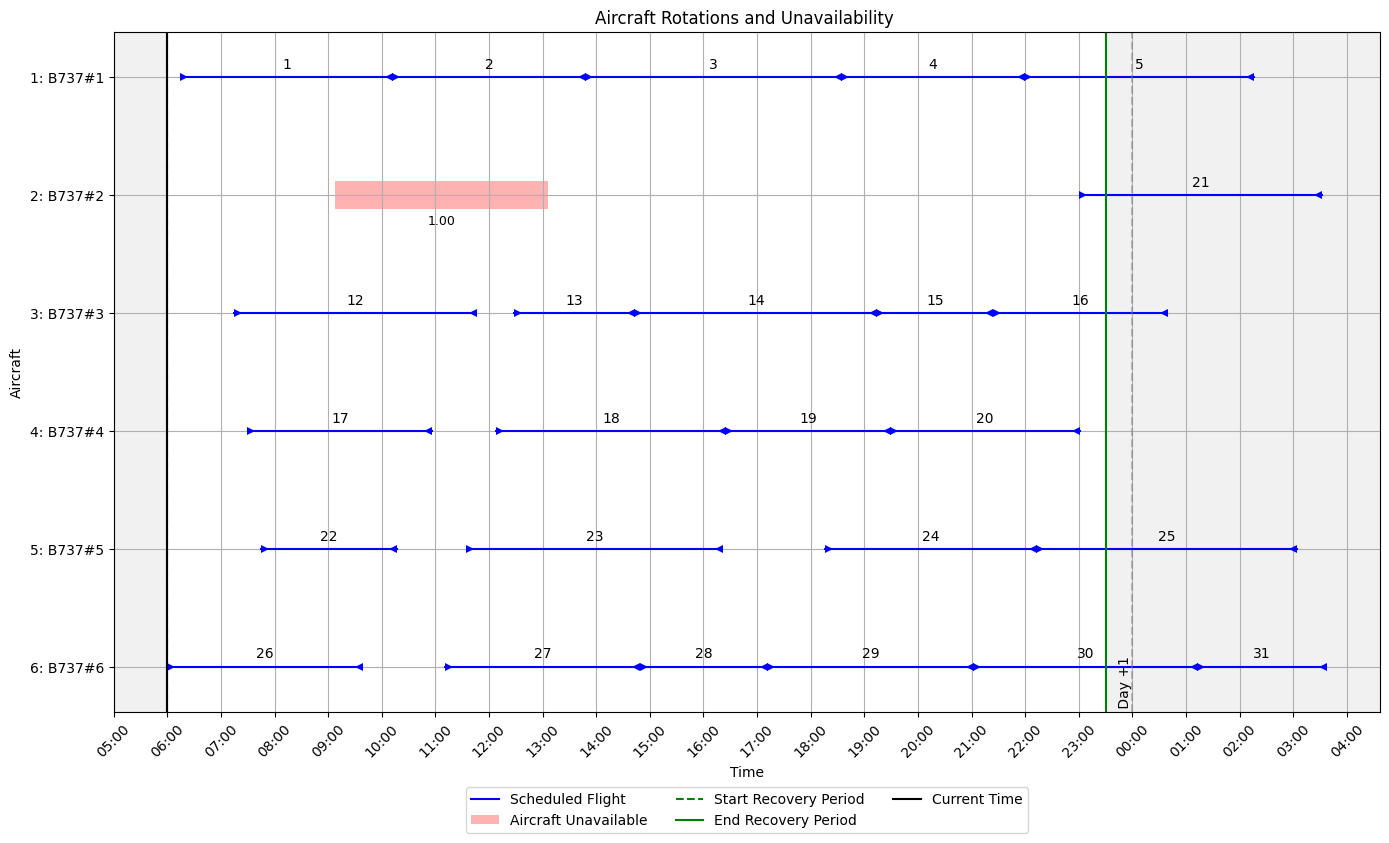

FLIGHTS DICT: {1: {'Orig': 'MAD', 'Dest': 'BCN', 'DepTime': '06:15', 'ArrTime': '10:12', 'PrevFlight': 0}, 2: {'Orig': 'FRA', 'Dest': 'ORY', 'DepTime': '10:12', 'ArrTime': '13:48', 'PrevFlight': 0}, 3: {'Orig': 'VIE', 'Dest': 'ORY', 'DepTime': '13:48', 'ArrTime': '18:34', 'PrevFlight': 0}, 4: {'Orig': 'ORY', 'Dest': 'MUC', 'DepTime': '18:34', 'ArrTime': '21:59', 'PrevFlight': 0}, 5: {'Orig': 'CPH', 'Dest': 'MUC', 'DepTime': '21:59', 'ArrTime': '02:16+1', 'PrevFlight': 0}, 12: {'Orig': 'BCN', 'Dest': 'TXL', 'DepTime': '07:15', 'ArrTime': '11:46', 'PrevFlight': 0}, 13: {'Orig': 'FRA', 'Dest': 'ZRH', 'DepTime': '12:28', 'ArrTime': '14:43', 'PrevFlight': 0}, 14: {'Orig': 'IST', 'Dest': 'CDG', 'DepTime': '14:43', 'ArrTime': '19:14', 'PrevFlight': 0}, 15: {'Orig': 'AMS', 'Dest': 'TXL', 'DepTime': '19:14', 'ArrTime': '21:24', 'PrevFlight': 0}, 16: {'Orig': 'IST', 'Dest': 'ORY', 'DepTime': '21:24', 'ArrTime': '00:39+1', 'PrevFlight': 0}, 17: {'Orig': 'BCN', 'Dest': 'IST', 'DepTime': '07:30', '

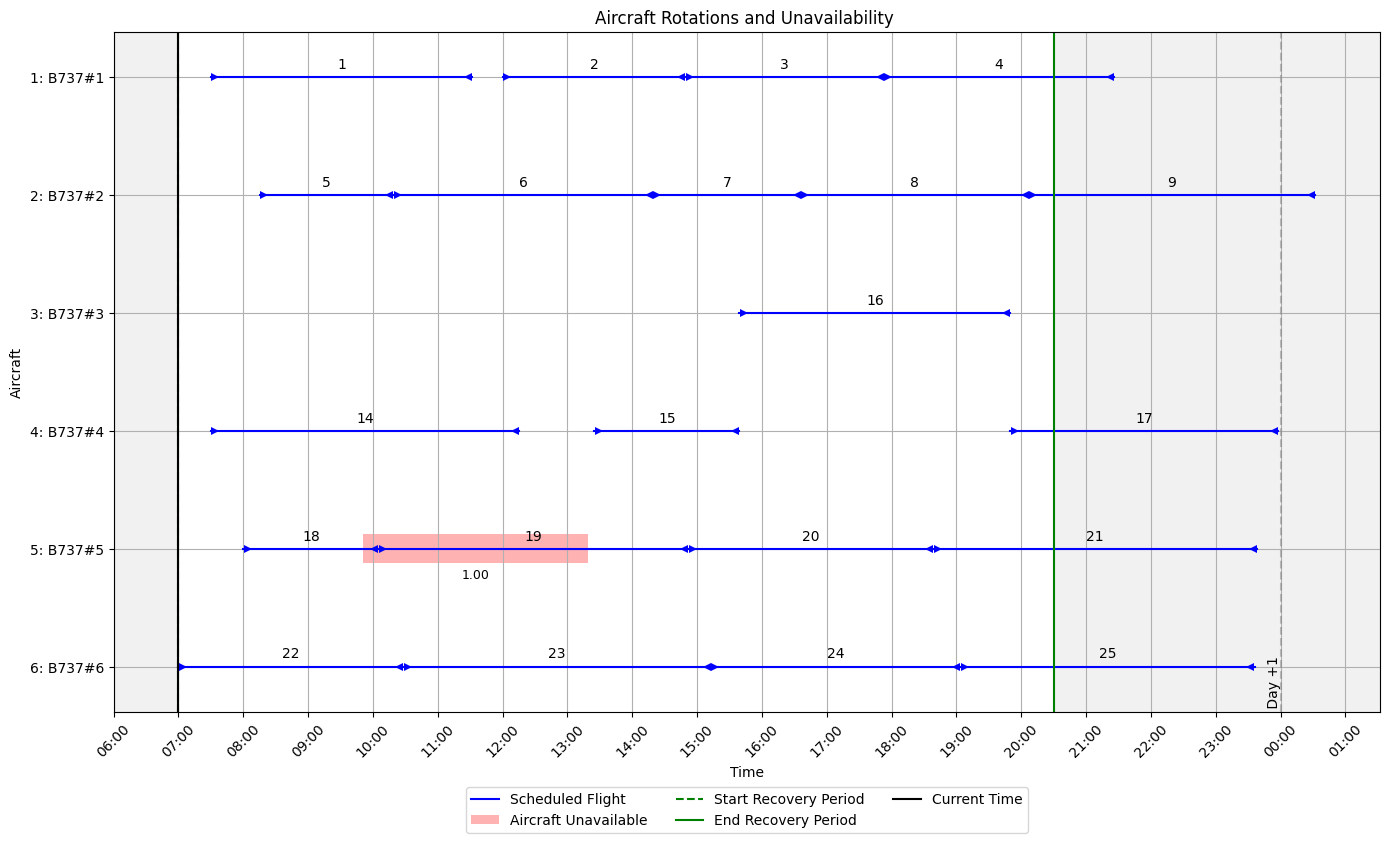

FLIGHTS DICT: {1: {'Orig': 'AMS', 'Dest': 'VIE', 'DepTime': '07:30', 'ArrTime': '11:32', 'PrevFlight': 0}, 2: {'Orig': 'VIE', 'Dest': 'CPH', 'DepTime': '12:00', 'ArrTime': '14:49', 'PrevFlight': 0}, 3: {'Orig': 'VIE', 'Dest': 'TXL', 'DepTime': '14:49', 'ArrTime': '17:53', 'PrevFlight': 0}, 4: {'Orig': 'ZRH', 'Dest': 'DUB', 'DepTime': '17:53', 'ArrTime': '21:26', 'PrevFlight': 0}, 5: {'Orig': 'FRA', 'Dest': 'BRU', 'DepTime': '08:15', 'ArrTime': '10:19', 'PrevFlight': 0}, 6: {'Orig': 'BCN', 'Dest': 'VIE', 'DepTime': '10:19', 'ArrTime': '14:19', 'PrevFlight': 0}, 7: {'Orig': 'DUB', 'Dest': 'IST', 'DepTime': '14:19', 'ArrTime': '16:36', 'PrevFlight': 0}, 8: {'Orig': 'CDG', 'Dest': 'DUB', 'DepTime': '16:36', 'ArrTime': '20:07', 'PrevFlight': 0}, 9: {'Orig': 'CDG', 'Dest': 'MAD', 'DepTime': '20:07', 'ArrTime': '00:32+1', 'PrevFlight': 0}, 14: {'Orig': 'MUC', 'Dest': 'AMS', 'DepTime': '07:30', 'ArrTime': '12:15', 'PrevFlight': 0}, 15: {'Orig': 'FRA', 'Dest': 'ZRH', 'DepTime': '13:25', 'ArrTim

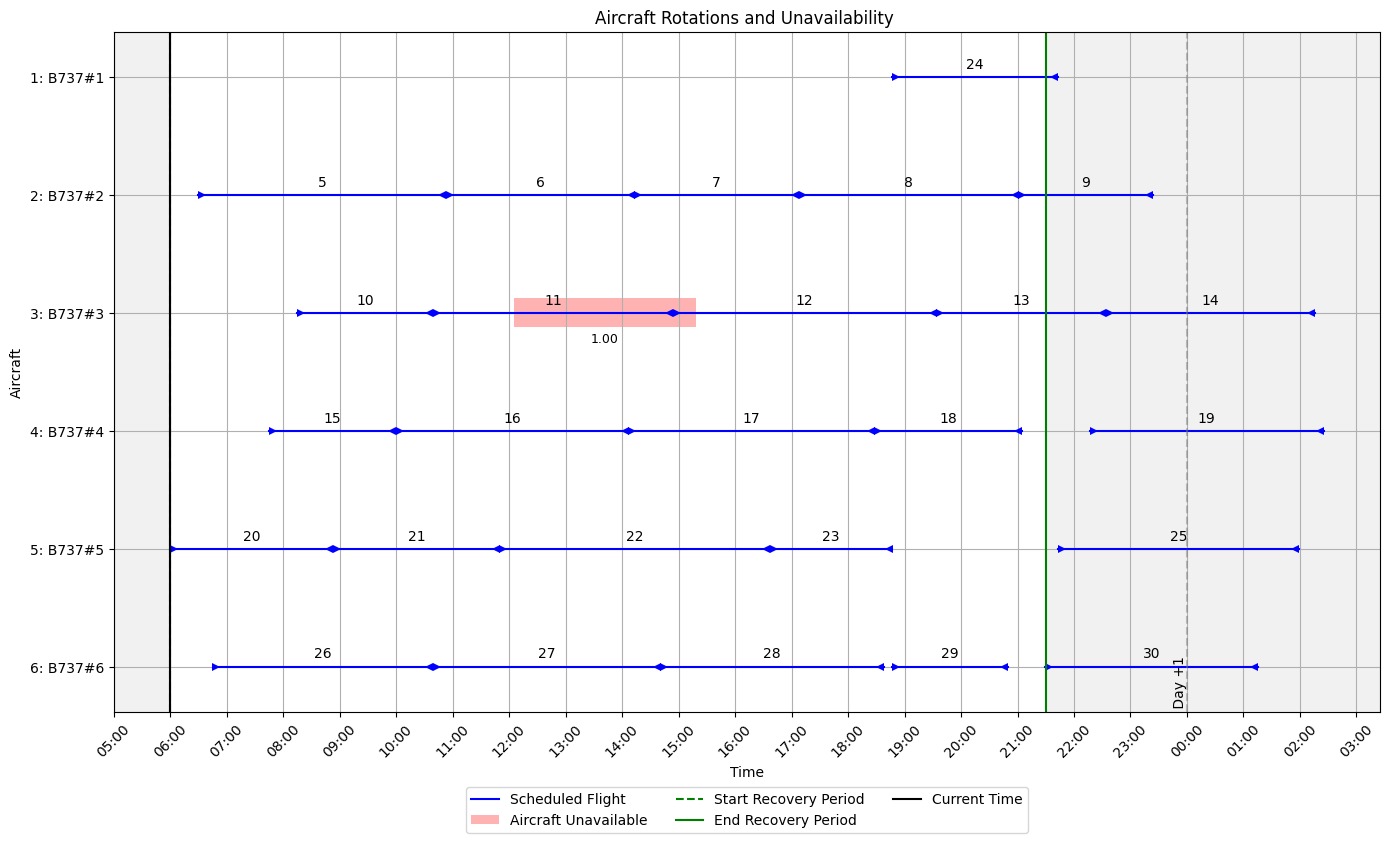

FLIGHTS DICT: {5: {'Orig': 'AMS', 'Dest': 'IST', 'DepTime': '06:30', 'ArrTime': '10:53', 'PrevFlight': 0}, 6: {'Orig': 'MAD', 'Dest': 'ORY', 'DepTime': '10:53', 'ArrTime': '14:13', 'PrevFlight': 0}, 7: {'Orig': 'TXL', 'Dest': 'LHR', 'DepTime': '14:13', 'ArrTime': '17:08', 'PrevFlight': 0}, 8: {'Orig': 'CPH', 'Dest': 'ZRH', 'DepTime': '17:08', 'ArrTime': '21:01', 'PrevFlight': 0}, 9: {'Orig': 'DUB', 'Dest': 'BCN', 'DepTime': '21:01', 'ArrTime': '23:24', 'PrevFlight': 0}, 10: {'Orig': 'MAD', 'Dest': 'ZRH', 'DepTime': '08:15', 'ArrTime': '10:39', 'PrevFlight': 0}, 11: {'Orig': 'MAD', 'Dest': 'CDG', 'DepTime': '10:39', 'ArrTime': '14:54', 'PrevFlight': 0}, 12: {'Orig': 'FRA', 'Dest': 'VIE', 'DepTime': '14:54', 'ArrTime': '19:34', 'PrevFlight': 0}, 13: {'Orig': 'IST', 'Dest': 'MUC', 'DepTime': '19:34', 'ArrTime': '22:34', 'PrevFlight': 0}, 14: {'Orig': 'ZRH', 'Dest': 'DUB', 'DepTime': '22:34', 'ArrTime': '02:16+1', 'PrevFlight': 0}, 15: {'Orig': 'MAD', 'Dest': 'VIE', 'DepTime': '07:45', 'Ar

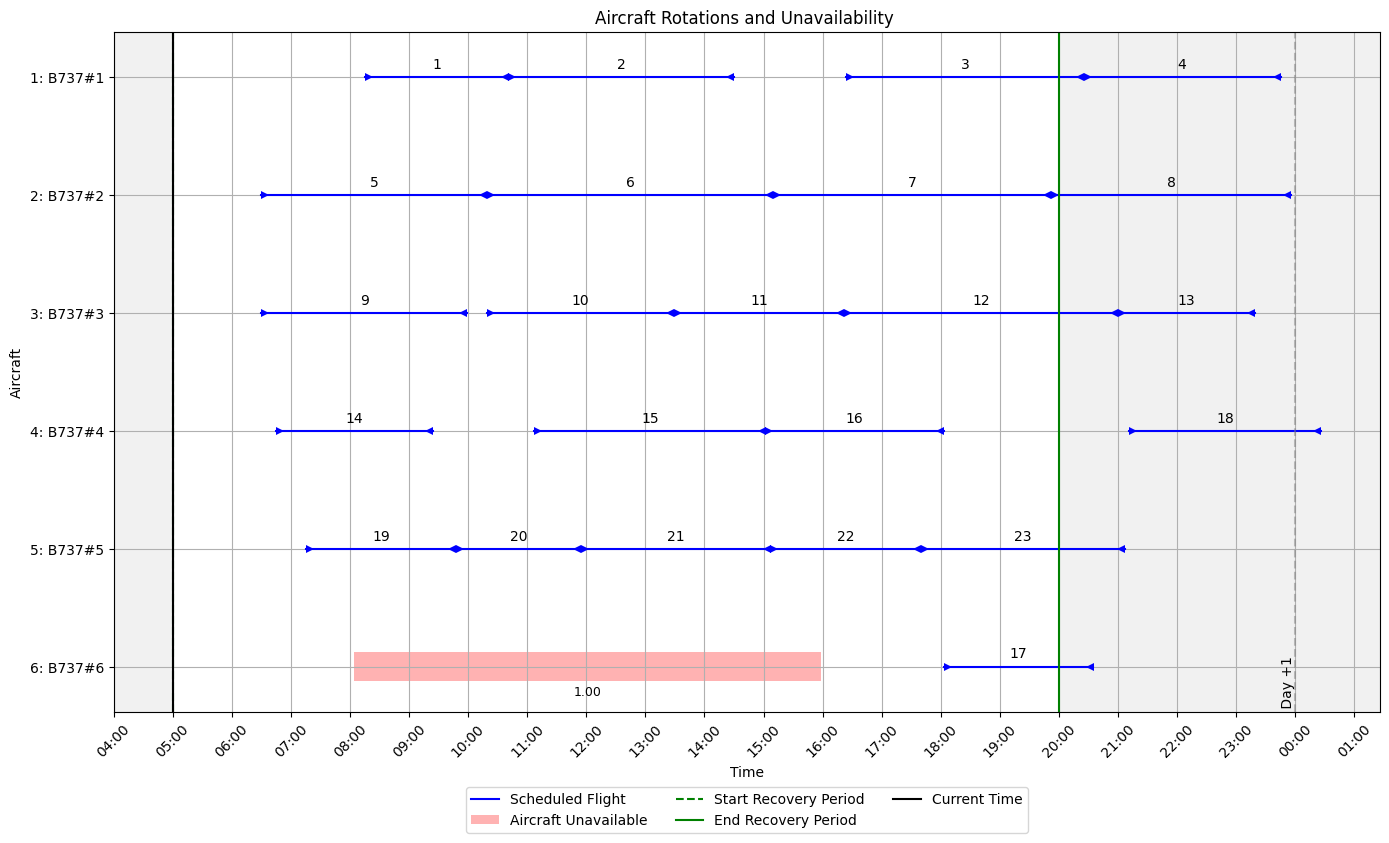

FLIGHTS DICT: {1: {'Orig': 'TXL', 'Dest': 'AMS', 'DepTime': '08:15', 'ArrTime': '10:41', 'PrevFlight': 0}, 2: {'Orig': 'AMS', 'Dest': 'LHR', 'DepTime': '10:41', 'ArrTime': '14:30', 'PrevFlight': 0}, 3: {'Orig': 'DUB', 'Dest': 'BCN', 'DepTime': '16:24', 'ArrTime': '20:25', 'PrevFlight': 0}, 4: {'Orig': 'DUB', 'Dest': 'VIE', 'DepTime': '20:25', 'ArrTime': '23:45', 'PrevFlight': 0}, 5: {'Orig': 'DUB', 'Dest': 'TXL', 'DepTime': '06:30', 'ArrTime': '10:19', 'PrevFlight': 0}, 6: {'Orig': 'MUC', 'Dest': 'BCN', 'DepTime': '10:19', 'ArrTime': '15:10', 'PrevFlight': 0}, 7: {'Orig': 'LHR', 'Dest': 'FRA', 'DepTime': '15:10', 'ArrTime': '19:52', 'PrevFlight': 0}, 8: {'Orig': 'MAD', 'Dest': 'AMS', 'DepTime': '19:52', 'ArrTime': '23:56', 'PrevFlight': 0}, 9: {'Orig': 'MUC', 'Dest': 'ZRH', 'DepTime': '06:30', 'ArrTime': '09:59', 'PrevFlight': 0}, 10: {'Orig': 'CPH', 'Dest': 'ORY', 'DepTime': '10:19', 'ArrTime': '13:29', 'PrevFlight': 0}, 11: {'Orig': 'FRA', 'Dest': 'IST', 'DepTime': '13:29', 'ArrTime'

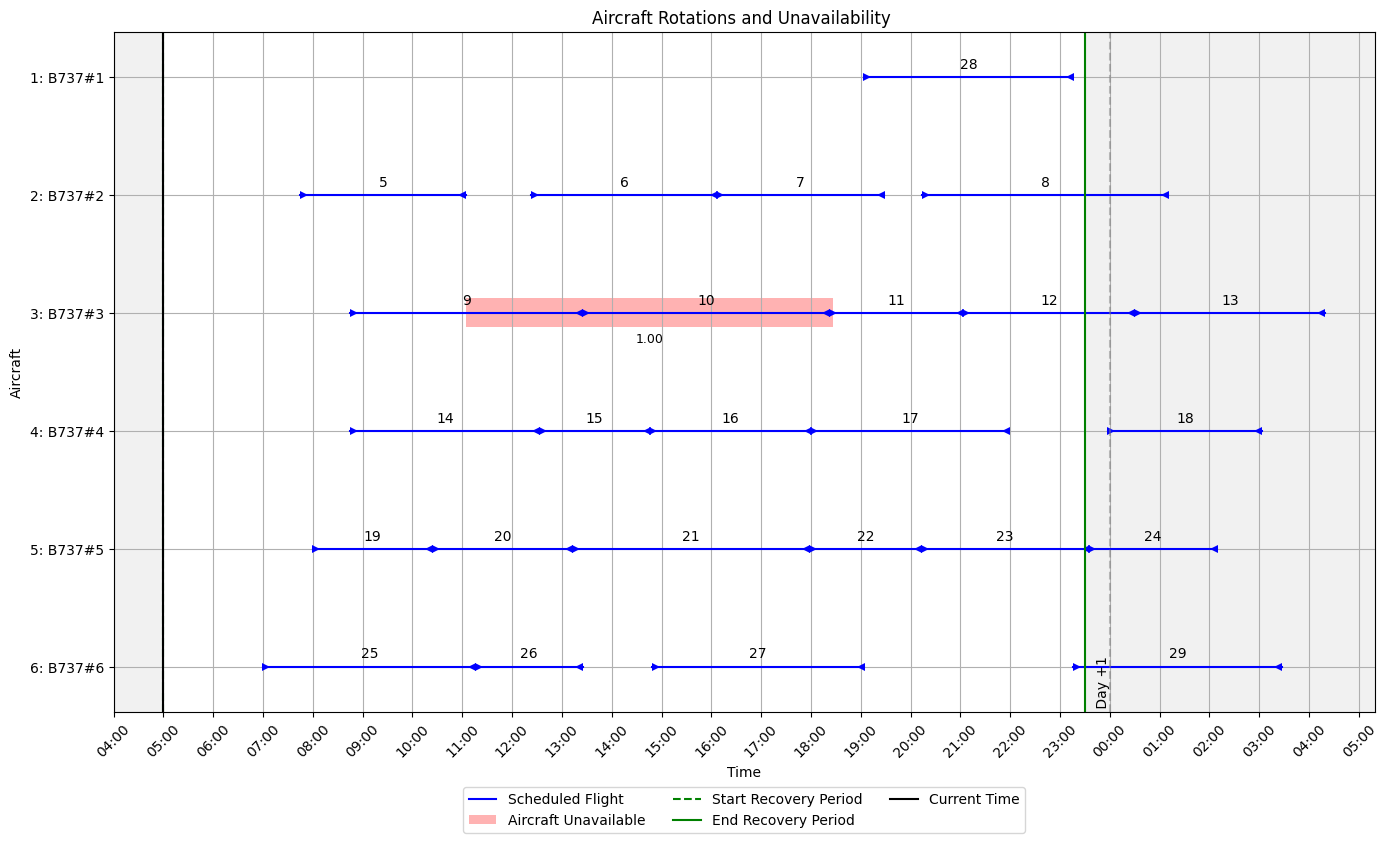

FLIGHTS DICT: {5: {'Orig': 'BRU', 'Dest': 'MUC', 'DepTime': '07:45', 'ArrTime': '11:04', 'PrevFlight': 0}, 6: {'Orig': 'VIE', 'Dest': 'CPH', 'DepTime': '12:23', 'ArrTime': '16:07', 'PrevFlight': 0}, 7: {'Orig': 'ZRH', 'Dest': 'MUC', 'DepTime': '16:07', 'ArrTime': '19:28', 'PrevFlight': 0}, 8: {'Orig': 'LHR', 'Dest': 'VIE', 'DepTime': '20:14', 'ArrTime': '01:10+1', 'PrevFlight': 0}, 9: {'Orig': 'BRU', 'Dest': 'LHR', 'DepTime': '08:45', 'ArrTime': '13:25', 'PrevFlight': 0}, 10: {'Orig': 'BRU', 'Dest': 'MUC', 'DepTime': '13:25', 'ArrTime': '18:22', 'PrevFlight': 0}, 11: {'Orig': 'VIE', 'Dest': 'FRA', 'DepTime': '18:22', 'ArrTime': '21:03', 'PrevFlight': 0}, 12: {'Orig': 'ORY', 'Dest': 'MAD', 'DepTime': '21:03', 'ArrTime': '00:30+1', 'PrevFlight': 0}, 13: {'Orig': 'IST', 'Dest': 'BRU', 'DepTime': '00:30+1', 'ArrTime': '04:19+1', 'PrevFlight': 0}, 14: {'Orig': 'MAD', 'Dest': 'VIE', 'DepTime': '08:45', 'ArrTime': '12:33', 'PrevFlight': 0}, 15: {'Orig': 'BCN', 'Dest': 'FRA', 'DepTime': '12:33

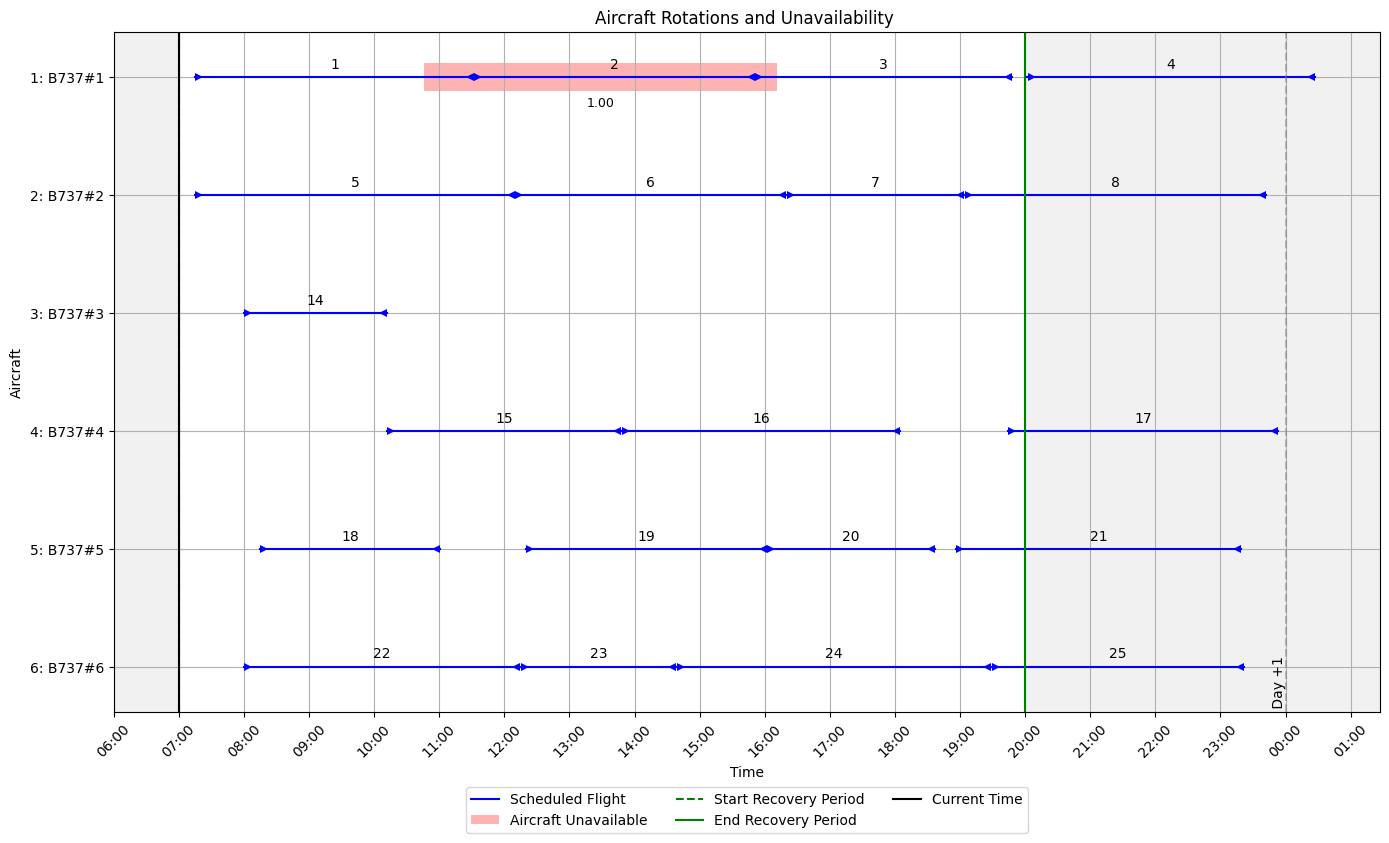

FLIGHTS DICT: {1: {'Orig': 'MAD', 'Dest': 'AMS', 'DepTime': '07:15', 'ArrTime': '11:32', 'PrevFlight': 0}, 2: {'Orig': 'ZRH', 'Dest': 'BCN', 'DepTime': '11:32', 'ArrTime': '15:51', 'PrevFlight': 0}, 3: {'Orig': 'FRA', 'Dest': 'MAD', 'DepTime': '15:51', 'ArrTime': '19:48', 'PrevFlight': 0}, 4: {'Orig': 'TXL', 'Dest': 'FRA', 'DepTime': '20:02', 'ArrTime': '00:27+1', 'PrevFlight': 0}, 5: {'Orig': 'DUB', 'Dest': 'CDG', 'DepTime': '07:15', 'ArrTime': '12:10', 'PrevFlight': 0}, 6: {'Orig': 'ORY', 'Dest': 'CPH', 'DepTime': '12:10', 'ArrTime': '16:20', 'PrevFlight': 0}, 7: {'Orig': 'FRA', 'Dest': 'AMS', 'DepTime': '16:20', 'ArrTime': '19:04', 'PrevFlight': 0}, 8: {'Orig': 'DUB', 'Dest': 'ZRH', 'DepTime': '19:04', 'ArrTime': '23:42', 'PrevFlight': 0}, 14: {'Orig': 'AMS', 'Dest': 'CDG', 'DepTime': '08:00', 'ArrTime': '10:12', 'PrevFlight': 0}, 15: {'Orig': 'ORY', 'Dest': 'CDG', 'DepTime': '10:12', 'ArrTime': '13:48', 'PrevFlight': 0}, 16: {'Orig': 'VIE', 'Dest': 'MUC', 'DepTime': '13:48', 'ArrTi

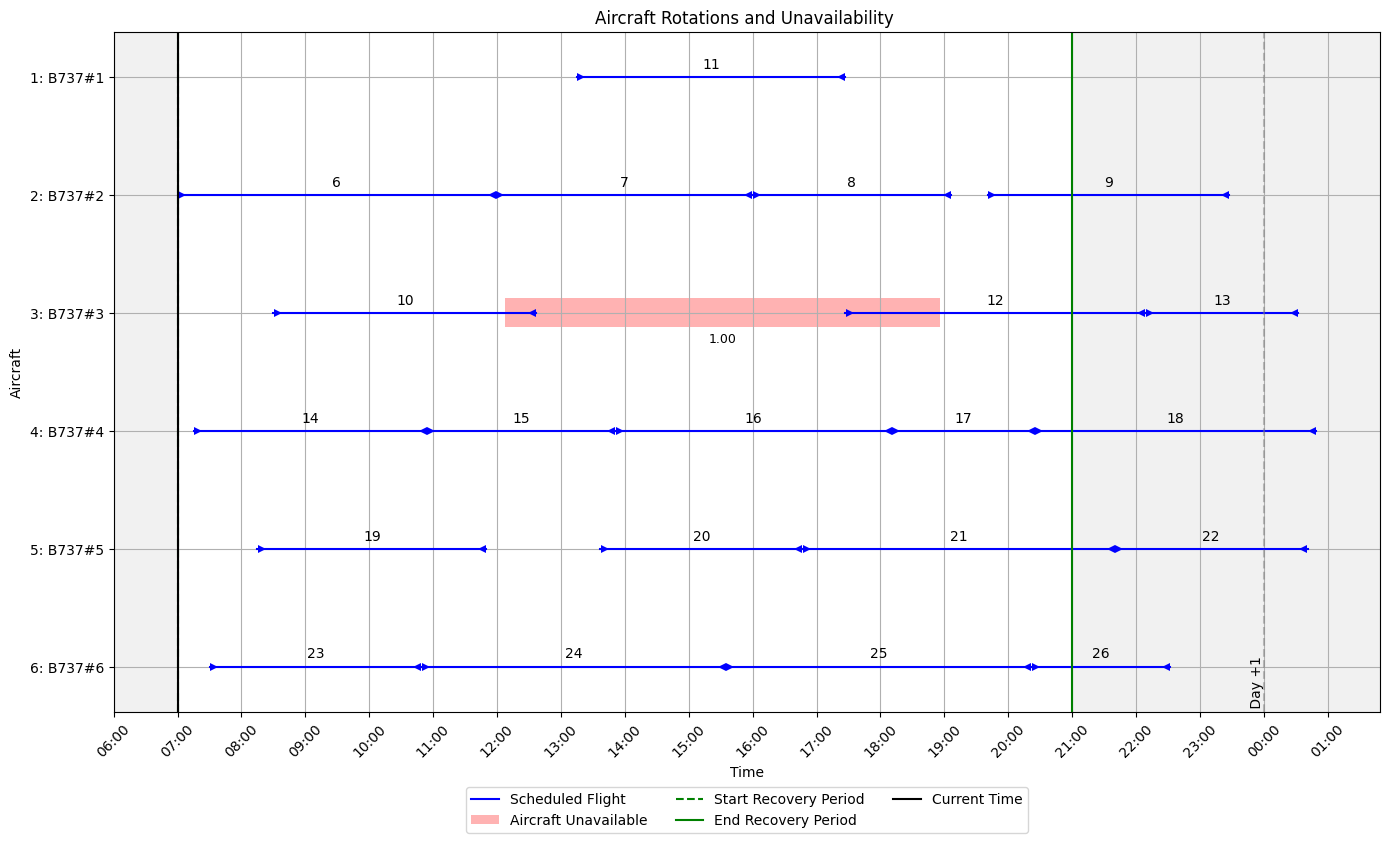

FLIGHTS DICT: {6: {'Orig': 'IST', 'Dest': 'AMS', 'DepTime': '07:00', 'ArrTime': '11:59', 'PrevFlight': 0}, 7: {'Orig': 'FRA', 'Dest': 'DUB', 'DepTime': '11:59', 'ArrTime': '16:00', 'PrevFlight': 0}, 8: {'Orig': 'BCN', 'Dest': 'AMS', 'DepTime': '16:00', 'ArrTime': '19:06', 'PrevFlight': 0}, 9: {'Orig': 'LHR', 'Dest': 'ORY', 'DepTime': '19:41', 'ArrTime': '23:27', 'PrevFlight': 0}, 10: {'Orig': 'CPH', 'Dest': 'MUC', 'DepTime': '08:30', 'ArrTime': '12:37', 'PrevFlight': 0}, 11: {'Orig': 'FRA', 'Dest': 'IST', 'DepTime': '13:15', 'ArrTime': '17:27', 'PrevFlight': 0}, 12: {'Orig': 'ORY', 'Dest': 'DUB', 'DepTime': '17:27', 'ArrTime': '22:09', 'PrevFlight': 0}, 13: {'Orig': 'BRU', 'Dest': 'BCN', 'DepTime': '22:09', 'ArrTime': '00:32+1', 'PrevFlight': 0}, 14: {'Orig': 'BCN', 'Dest': 'VIE', 'DepTime': '07:15', 'ArrTime': '10:54', 'PrevFlight': 0}, 15: {'Orig': 'FRA', 'Dest': 'IST', 'DepTime': '10:54', 'ArrTime': '13:51', 'PrevFlight': 0}, 16: {'Orig': 'TXL', 'Dest': 'CDG', 'DepTime': '13:51', 'A

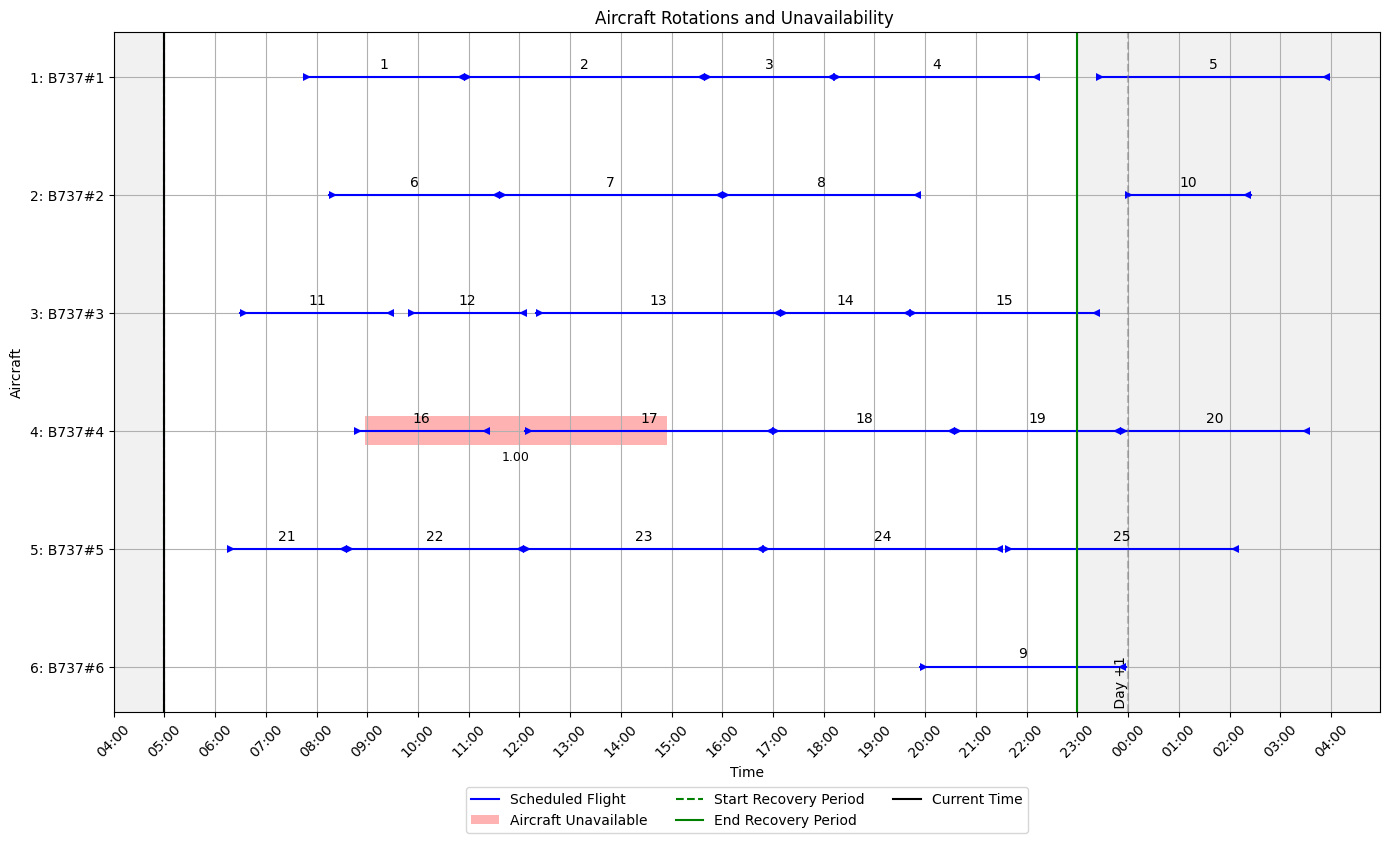

FLIGHTS DICT: {1: {'Orig': 'LHR', 'Dest': 'CPH', 'DepTime': '07:45', 'ArrTime': '10:55', 'PrevFlight': 0}, 2: {'Orig': 'MAD', 'Dest': 'TXL', 'DepTime': '10:55', 'ArrTime': '15:39', 'PrevFlight': 0}, 3: {'Orig': 'MAD', 'Dest': 'IST', 'DepTime': '15:39', 'ArrTime': '18:12', 'PrevFlight': 0}, 4: {'Orig': 'CPH', 'Dest': 'IST', 'DepTime': '18:12', 'ArrTime': '22:15', 'PrevFlight': 0}, 5: {'Orig': 'BCN', 'Dest': 'CPH', 'DepTime': '23:23', 'ArrTime': '03:58+1', 'PrevFlight': 0}, 6: {'Orig': 'FRA', 'Dest': 'AMS', 'DepTime': '08:15', 'ArrTime': '11:36', 'PrevFlight': 0}, 7: {'Orig': 'FRA', 'Dest': 'TXL', 'DepTime': '11:36', 'ArrTime': '16:00', 'PrevFlight': 0}, 8: {'Orig': 'LHR', 'Dest': 'FRA', 'DepTime': '16:00', 'ArrTime': '19:54', 'PrevFlight': 0}, 9: {'Orig': 'CPH', 'Dest': 'ZRH', 'DepTime': '19:54', 'ArrTime': '23:57', 'PrevFlight': 0}, 10: {'Orig': 'MAD', 'Dest': 'DUB', 'DepTime': '23:57', 'ArrTime': '02:25+1', 'PrevFlight': 0}, 11: {'Orig': 'IST', 'Dest': 'CPH', 'DepTime': '06:30', 'ArrT

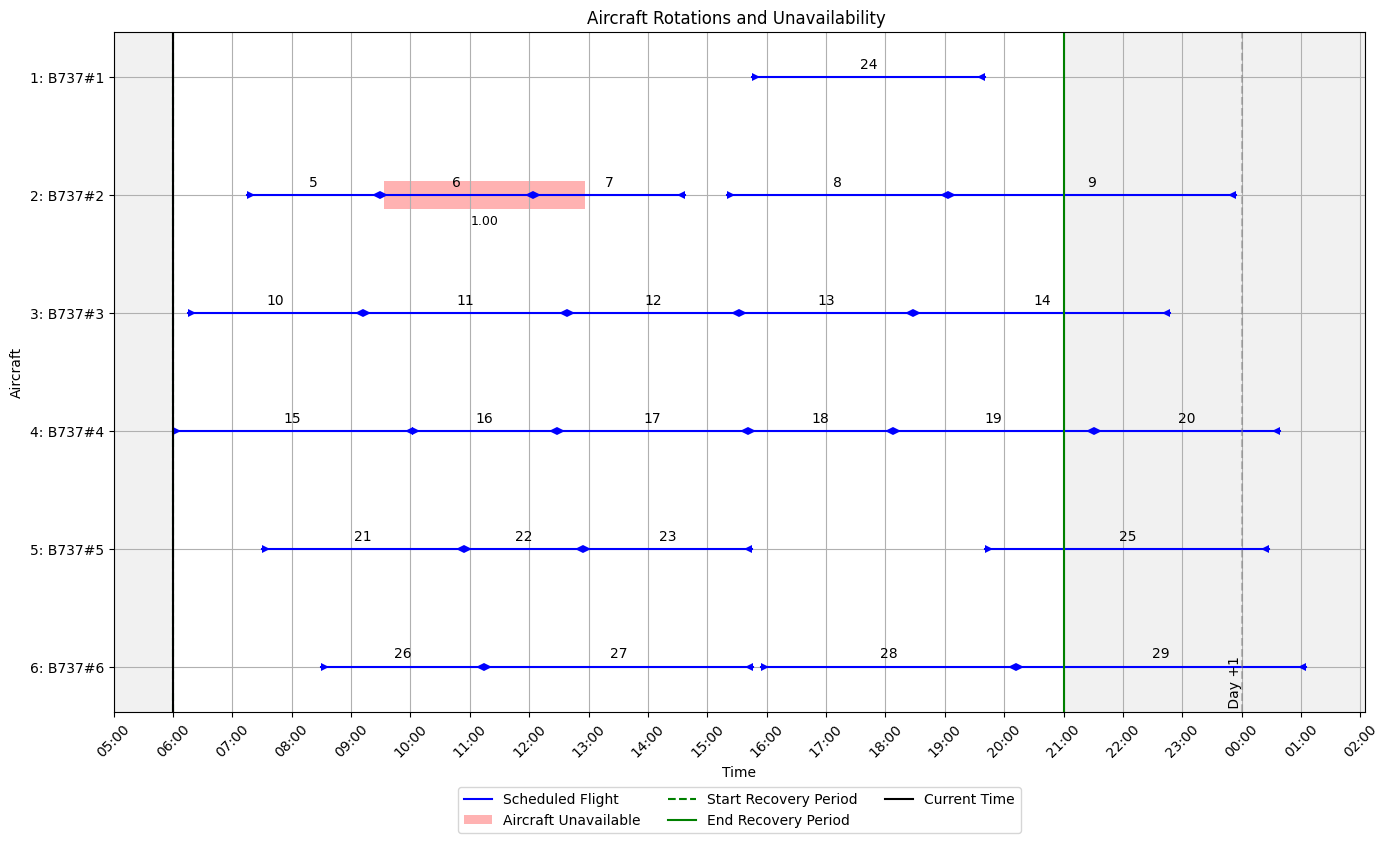

FLIGHTS DICT: {5: {'Orig': 'FRA', 'Dest': 'ORY', 'DepTime': '07:15', 'ArrTime': '09:29', 'PrevFlight': 0}, 6: {'Orig': 'VIE', 'Dest': 'BCN', 'DepTime': '09:29', 'ArrTime': '12:04', 'PrevFlight': 0}, 7: {'Orig': 'ORY', 'Dest': 'BRU', 'DepTime': '12:04', 'ArrTime': '14:37', 'PrevFlight': 0}, 8: {'Orig': 'VIE', 'Dest': 'DUB', 'DepTime': '15:20', 'ArrTime': '19:03', 'PrevFlight': 0}, 9: {'Orig': 'CPH', 'Dest': 'CDG', 'DepTime': '19:03', 'ArrTime': '23:54', 'PrevFlight': 0}, 10: {'Orig': 'TXL', 'Dest': 'FRA', 'DepTime': '06:15', 'ArrTime': '09:12', 'PrevFlight': 0}, 11: {'Orig': 'CPH', 'Dest': 'DUB', 'DepTime': '09:12', 'ArrTime': '12:38', 'PrevFlight': 0}, 12: {'Orig': 'CDG', 'Dest': 'ZRH', 'DepTime': '12:38', 'ArrTime': '15:32', 'PrevFlight': 0}, 13: {'Orig': 'CDG', 'Dest': 'BCN', 'DepTime': '15:32', 'ArrTime': '18:28', 'PrevFlight': 0}, 14: {'Orig': 'LHR', 'Dest': 'AMS', 'DepTime': '18:28', 'ArrTime': '22:48', 'PrevFlight': 0}, 15: {'Orig': 'ZRH', 'Dest': 'BRU', 'DepTime': '06:00', 'ArrT

In [2]:
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
import os
import random
from src.environment import AircraftDisruptionEnv
from datetime import datetime
from scripts.utils import print_state_nicely

env_type = 'proactive'

data_root_folder = "../data/Training/6ac-100-deterministic/"
# Verify that the root folder exists
if not os.path.exists(data_root_folder):
    raise FileNotFoundError(f"The data root folder does not exist: {data_root_folder}")

# Get the list of scenarios
scenarios = [scenario for scenario in os.listdir(data_root_folder) if os.path.isdir(os.path.join(data_root_folder, scenario))]

# Randomly select 10 scenarios and sort alphabetically
selected_scenarios = sorted(random.sample(scenarios, min(10, len(scenarios))))

# Process each selected scenario
for scenario_name in selected_scenarios:
    scenario_path = os.path.join(data_root_folder, scenario_name)
    
    print(f"Processing scenario: {scenario_name}")

    # Verify that the scenario exists
    if not os.path.exists(scenario_path):
        print(f"Scenario {scenario_name} does not exist. Skipping...")
        continue

    # Load scenario data
    data_dict = load_scenario_data(scenario_path)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Print configuration details for verification
    # print(config_dict)

    # print alt_aircraft_dict
    print(alt_aircraft_dict)

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )
    # Print state with print_state_nicely_proactive
    print_state_nicely(env.state)
    
    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )

    # Define the recovery period based on provided configuration
    start_date = config_dict['RecoveryPeriod']['StartDate']
    start_time = config_dict['RecoveryPeriod']['StartTime']
    end_date = config_dict['RecoveryPeriod']['EndDate']
    end_time = config_dict['RecoveryPeriod']['EndTime']
    start_datetime = datetime.strptime(f"{start_date} {start_time}", '%d/%m/%y %H:%M')

    # Plot the state for the current scenario
    print(f"Plotting state for scenario: {scenario_name}")
    state_plotter.plot_state(flights_dict, [], [], set(), env.current_datetime)

    print(f"FLIGHTS DICT: {flights_dict}")

print("All scenarios processed successfully.")
